In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import time 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from functools import partial

def initialization():
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

In [2]:
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname='../Fonts/SourceHanSerifSC-Medium.otf', size=12)

In [3]:
def plot_image(image):
    # "nearest" 分辨率不匹配时,只显示图像而不尝试在像素之间进行插值
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")


def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# CNN架构 CNN Architectures

<img src="../images/other/14-6.png" width="500">

## 使用CNN处理MNIST数据集

以下是实现简单的`CNN`来处理`Fashion MNIST`数据集的方法.

In [4]:
initialization()

In [5]:
# 1. 加载数据集
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# 2. 特征缩放
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

# 3. 创建验证集
X_train, X_val = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_val = y_train_full[:-5000], y_train_full[-5000:]

# 4. 输入标准化
pixel_mean = X_train.mean(axis=0, keepdims=True)
pixel_std = X_train.std(axis=0, keepdims=True) + 1e-7

X_train = (X_train - pixel_mean) / pixel_std
X_val = (X_val - pixel_mean) / pixel_std
X_test = (X_test - pixel_mean) / pixel_std

X_train.shape, X_val.shape, X_test.shape

((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

In [6]:
# 5. 添加1个维度 ->( batch_size, height, width, channels )
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

X_train.shape

(55000, 28, 28, 1)

In [7]:
# 6. 创建模型
from functools import partial

default_Conv2D_layer = partial(keras.layers.Conv2D,
                               kernel_size=3,
                               activation=keras.activations.relu,
                               padding='SAME')

model = keras.models.Sequential([
    default_Conv2D_layer(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    
    keras.layers.MaxPooling2D(pool_size=2),
    default_Conv2D_layer(filters=128),
    default_Conv2D_layer(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    default_Conv2D_layer(filters=256),
    default_Conv2D_layer(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=keras.activations.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation=keras.activations.softmax),
])

2022-10-26 11:14:15.520271: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-26 11:14:15.819585: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2981 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


- 第一层使用64个相当大的滤波器(7×7),但没有步幅,因为输入图像不是很大.


- 接下来,我们有一个`MaxPooling`层,池化大小为2,因此它将每个空间维度除以2


- 然后我们重复相同的结构两次:两个卷积层,紧接着是一个`MaxPooling`层。对于较大的图像,我们可以重复多次此结构.


- 请注意随着`CNN`向输出层延伸,滤波器的数量会增加:增长是有意义的,因为低层特征的数量通常很少(例如小圆圈、水平线),但是有很多不同的方法可以将它们组合成更高层次的特征。通常的做法是在每个`Pooling`层之后将滤波器的数量加倍:由于池化层将每个空间维度除以2,所以我们能负担得起对下一层特征图数量加倍而不必担心参数数量、内存使用量或计算量的暴增.


- 接下来是全连接的网络,该网络由两个隐藏的密集层和一个密集输出层组成。请注意,我们必须将其输入`Flatten`展平,因为密集网络需要每个实例的一维特征阵列,我们还加了两个`dropout`层,每层的`dropout`率均为50%,以减少过拟合的情况.

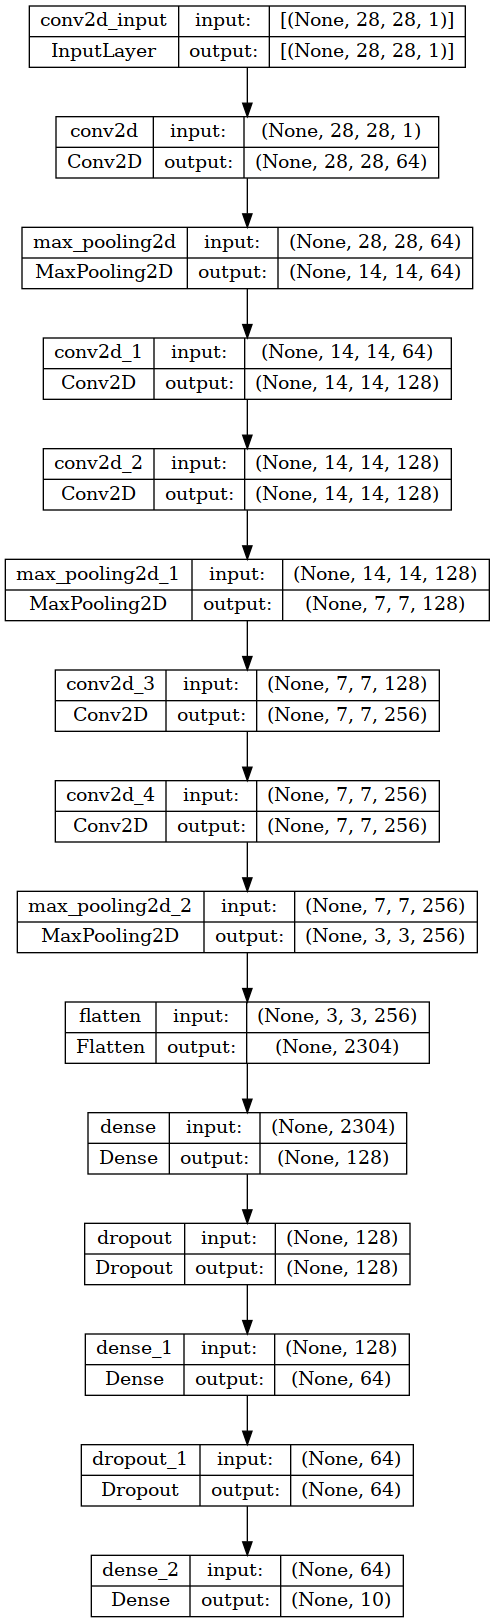

In [8]:
keras.utils.plot_model(model,
                       "../models/plot_model/CNN_example_model.png",
                       show_shapes=True)

In [9]:
# 7. 编译模型
optimizer = keras.optimizers.Nadam(learning_rate=0.001,
                                   beta_1=0.9,
                                   beta_2=0.999)
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=optimizer,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [10]:
# 8. 训练模型
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_val, y_val))

Epoch 1/10


2022-10-26 11:14:17.310116: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


1719/1719 [==============================] - 29s 16ms/step - loss: 0.7223 - sparse_categorical_accuracy: 0.7484 - val_loss: 0.3614 - val_sparse_categorical_accuracy: 0.8612
Epoch 2/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.4312 - sparse_categorical_accuracy: 0.8567 - val_loss: 0.3218 - val_sparse_categorical_accuracy: 0.8874
Epoch 3/10
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3643 - sparse_categorical_accuracy: 0.8774 - val_loss: 0.3237 - val_sparse_categorical_accuracy: 0.8870
Epoch 4/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3367 - sparse_categorical_accuracy: 0.8886 - val_loss: 0.3056 - val_sparse_categorical_accuracy: 0.8936
Epoch 5/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3078 - sparse_categorical_accuracy: 0.8962 - val_loss: 0.3039 - val_sparse_categorical_accuracy: 0.8928
Epoch 6/10
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2959 - spar

In [11]:
# 9. 评估模型
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
y_pred = model.predict(X_new)

1/1 [==============================] - 0s 158ms/step


## LeNet-5

### 原理

基于 `LeNet-5` 的手写数字识别系统在 20 世纪 90 年代被美国很多银行使用，用来识别支票上面的手写数字.

<img src="../images/other/14-7.png" width="600">

| 层 | 类型 | 特征图 | 大小 | Kernel size | Stride | 激活函数 |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| Out | Fully connected | - | 10 | - | - | RBF |
| F6 | Fully connected | - | 84 | - | - | tanh |
| C5 | Convolution | 120 | 1x1 | 5×5 | 1 | tanh |
| S4 | Avg pooling | 16 | 5x5 | 2x2 | 2 | tanh |
| C3 | Convolution | 16 | 10x10 | 5x5 | 1 | tanh |
| S2 | Avg pooling | 6 | 14x14 | 2x2 | 2 | tanh |
| C1 | Convolution | 6 | 28x28 | 5x5 | 1 | tanh |
| In | Input | 1 | 32x32 | - | - | - |

- `IN 层`:`MNIST`的图像为28×28像素,将其零填充为$32×32=1024$并在送入网络之前进行了归一化.在网络的其他部分不使用任何填充,这使得图像随着网络延展而尺寸不断缩小的原因.


- <img src="../images/other/14-8.png" >


详解:https://www.cnblogs.com/hls91/p/10882403.html

### 使用Keras实现LeNet-5

In [12]:
initialization()

1. 加载`MNIST`数据集,查看数字分布和图像

In [13]:
mnist = keras.datasets.mnist
(X_train_full, y_train_full),(X_test, y_test) = mnist.load_data()

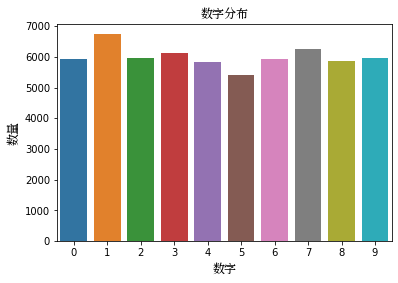

In [56]:
sns.countplot(y_train_full)

plt.title('数字分布', font_properties=my_font)
plt.xlabel('数字', font_properties=my_font)
plt.ylabel("数量", font_properties=my_font)

plt.show()

In [15]:
def plot_digits(X, y):
    for i in range(20):
        plt.subplot(5, 4, i + 1)

        plt.tight_layout()  # 自动调整子图参数
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title('数字:{}'.format(y[i]), font_properties=my_font)
        plt.axis("off")

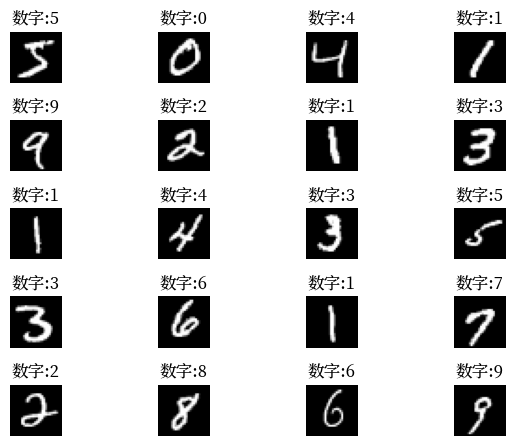

In [16]:
plot_digits(X_train_full, y_train_full)

2. 创建验证集

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full,
                                                  test_size=0.2,
                                                  stratify=y_train_full,  # 按原数据中各类比例进行分配   
                                                  shuffle=True,
                                                  random_state=42)
X_train.shape, X_val.shape, X_test.shape

((48000, 28, 28), (12000, 28, 28), (10000, 28, 28))

In [18]:
X_train.dtype

dtype('uint8')

3. 特征缩放,标准化

In [19]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [20]:
pixel_mean = X_train.mean(axis=0, keepdims=True)
pixel_std = X_train.std(axis=0, keepdims=True) + 1e-7

X_train = (X_train - pixel_mean) / pixel_std
X_val = (X_val - pixel_mean) / pixel_std
X_test = (X_test - pixel_mean) / pixel_std

3. 添加1个维度

In [21]:
#->( batch_size, height, width, channels )
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

X_train.shape

(48000, 28, 28, 1)

4. 创建模型

<img src="../images/other/14-7.png" width="600">

In [22]:
model = keras.models.Sequential([
    # 1. IN 层 + C1卷积层
    keras.layers.Conv2D(filters=6,         # 滤波器数量
                        kernel_size=5,      # 滤波器宽高
                        strides=1, 
                        padding="SAME",     # 零填充 P=2
                        activation=keras.activations.relu,
                        input_shape=(28,28,1),
                        name="C1"), 
    # ((N+2P-F)/S)+1 = ((28+4-5)/1)+1 = 28x28
    # Output_shape:[batches x 28 x 28 x 6]
    
    
    # 2. S2池化层
    keras.layers.AvgPool2D(pool_size=2,
                           strides=2,
                           padding='VALID',
                           name="S2"),
    # ((N+2P-F)/S)+1 = ((28-2)/2)+1 = 14x14
    # Output_shape:[batches x 14 x 14 x 6]
    
    # 3. C3卷积层
    keras.layers.Conv2D(filters=16,        
                        kernel_size=5,     
                        strides=1, 
                        padding="VALID",     
                        activation=keras.activations.relu,
                        name="C3"), 
    # ((N+2P-F)/S)+1 = ((16-5)/1)+1 = 10x10
    # Output_shape:[batches x 10 x 10 x 16]    
    
    # 4. C4池化层
    keras.layers.AvgPool2D(pool_size=2,
                           strides=2,
                           padding='VALID',
                           name="C4"),
    # ((N+2P-F)/S)+1 = ((10-2)/2)+1 = 5x5
    # Output_shape:[batches x 5 x 5 x 16]  
    
    # 5. C5卷积层
#     keras.layers.Conv2D(filters=120,        
#                         kernel_size=1,     
#                         strides=1, 
#                         padding="VALID",     
#                         activation=keras.activations.relu,
#                         name="C5"), 
#     # ((N+2P-F)/S)+1 = ((5-1)/1)+1 = 5x5
#     # Output_shape:[batches x 15 x 5 x 120]       
    # 在LeNet-5论文中将这一层称为卷积层，但是因为过滤器的大小就是5*5，
    # 所以和全连接层没有区别。如果将5*5*16矩阵中的节点拉成一个向量，那么这一层和全连接层就一样了。
    # 本层的输出节点个数为120，总共有5*5*16*120+120=48120个参数
    keras.layers.Flatten(),
    keras.layers.Dense(120,activation=keras.activations.relu,
                       name="C5"),

    # 6. F6全连接层
    keras.layers.Dense(84,activation=keras.activations.relu,
                       name="F6"),
    
    # 7. Out层
    keras.layers.Dense(10,activation=keras.activations.softmax,
                       name="Out"),   
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 28, 28, 6)         156       
                                                                 
 S2 (AveragePooling2D)       (None, 14, 14, 6)         0         
                                                                 
 C3 (Conv2D)                 (None, 10, 10, 16)        2416      
                                                                 
 C4 (AveragePooling2D)       (None, 5, 5, 16)          0         
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 C5 (Dense)                  (None, 120)               48120     
                                                                 
 F6 (Dense)                  (None, 84)                1

4. 编译模型

In [24]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=5e-4),
              metrics=["accuracy"])

5. 训练模型

In [25]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_val,y_val))

Epoch 1/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2743 - accuracy: 0.9167 - val_loss: 4.1343 - val_accuracy: 0.9585
Epoch 2/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0917 - accuracy: 0.9722 - val_loss: 5.7494 - val_accuracy: 0.9737
Epoch 3/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0647 - accuracy: 0.9795 - val_loss: 4.9965 - val_accuracy: 0.9785
Epoch 4/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0499 - accuracy: 0.9844 - val_loss: 2.4799 - val_accuracy: 0.9820
Epoch 5/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0419 - accuracy: 0.9862 - val_loss: 3.1151 - val_accuracy: 0.9845
Epoch 6/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0350 - accuracy: 0.9885 - val_loss: 8.0753 - val_accuracy: 0.9862
Epoch 7/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0301 - accuracy: 0.9903 - val_loss: 8.4536 - val_accuracy:

6. 评估模型

In [26]:
score = model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.5741 - accuracy: 0.9866


In [27]:
model.save('../models/LeNet_5_model.h5')

### 使用PyTorch实现LeNet-5

- 模型搭建

<img src="../images/other/14-7.png" width="600">

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [29]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=32 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):  # 定义正向传播过程
        x = F.relu(self.conv1(
            x))  # input(3, 32, 32) -> (32-5+2*0)/1+1=28 -> output(16, 28, 28)
        x = self.pool1(x)  # output(16, 14, 14)
        x = F.relu(self.conv2(x))  # output(32, 10, 10)
        x = self.pool2(x)  # output(32, 5, 5)
        # view()：相当于resize()的功能 -1就代表这个位置由其他位置的数字来推断
        x = x.view(-1, 32 * 5 *
                   5)  # output(32*5*5)  展平成一维数据  # x = x.view(-1, 32*5*5)
        x = F.relu(self.fc1(x))  # output(120)
        x = F.relu(self.fc2(x))  # output(84)
        x = self.fc3(x)  # output(10)
        return x

- 数据集导入

    Pytorch Tensor的通道排序:`[ batch, channel, height, width]`

In [30]:
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [31]:
# 图像预处理
transform = transforms.Compose([
    transforms.ToTensor(),  # 转换为Tensor格式
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 标准化
])

In [32]:
# 50000张训练图片
# 第一次使用时要将download设置为True才会自动去下载数据集
train_set = torchvision.datasets.CIFAR10('../datasets/',
                                         train=True,
                                         download=False,
                                         transform=transform)

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=36,
                                           shuffle=True,
                                           num_workers=0)

In [33]:
# 10000张验证图片
# 第一次使用时要将download设置为True才 会自动去下载数据集
val_set = torchvision.datasets.CIFAR10('../datasets/', 
                                       train=False,
                                       download=False,
                                       transform=transform)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=10000,
                                         shuffle=False, num_workers=0)

In [34]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

In [35]:
# 转换为迭代器
val_data_iter = iter(val_loader)
val_image, val_label = val_data_iter.__next__()

  cat  ship  ship plane


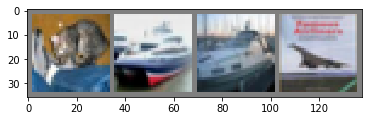

In [27]:
# 显示验证集中的4张图片
# 注意:val_loader的batch_size=4
def imshow(image):
    timage = image / 2 + 0.5  # 反标准化:input=output*0.5+0.5=output/2+0.5
    npimg = timage.numpy()  # [channel, height, width]
    img = np.transpose(npimg, (1, 2, 0))
    plt.imshow(img)
    plt.show()


print(" ".join("%5s" % classes[val_label[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(val_image))

- 训练模型

In [37]:
import torch.optim as optim

In [38]:
model = LeNet()
# 定义损失函数 CrossEntropyLoss()包含了Softmax相关操作因此在模型定义中无需添加
loss_fn = nn.CrossEntropyLoss()
# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
epochs = 5

> 为什么每计算一个`batch`，就需要调用一次`optimizer.zero_grad()`:
如果不清除历史梯度，就会对计算的历史梯度进行累加,通过这个特性你能够变相实现一个很大 `batch`数值的训练

In [40]:
for epoch in range(epochs):  # 多次循环数据集
    runing_loss = 0.0  # 损失累加器

    for step, data in enumerate(train_loader, start=0):
        inputs, labels = data

        optimizer.zero_grad()  # 将参数梯度归零

        outputs = model(inputs)  # 前向传播
        loss = loss_fn(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 参数更新

        runing_loss += loss.item()

        # 打印信息
        if step % 500 == 499:
            # 上下文管理器，被该语句wrap起来的部分将不会追踪梯度。避免出现内存爆炸
            # 如果不加在验证阶段仍然会计算训练梯度
            with torch.no_grad():
                outputs = model(val_image)
                preds = torch.max(outputs, dim=1)[1]  # 只取标签
                # torch.eq():逐元素的比较
                acc = torch.eq(preds, val_label).sum().item() / val_label.size(0)

                print('[%d, %5d] train_loss:%.3f test_acc:%.3f' %
                      (epoch + 1, step + 1, runing_loss / 500, acc))
                runing_loss = 0.0

print('Finished Training')

[1,   500] train_loss:1.725 test_acc:0.449
[1,  1000] train_loss:1.437 test_acc:0.523
[2,   500] train_loss:1.246 test_acc:0.572
[2,  1000] train_loss:1.179 test_acc:0.580
[3,   500] train_loss:1.041 test_acc:0.612
[3,  1000] train_loss:1.027 test_acc:0.630
[4,   500] train_loss:0.934 test_acc:0.655
[4,  1000] train_loss:0.928 test_acc:0.619
[5,   500] train_loss:0.854 test_acc:0.657
[5,  1000] train_loss:0.861 test_acc:0.674
Finished Training


In [41]:
save_path = '../models/LeNet.pth'
torch.save(model.state_dict(), save_path)

- 预测

In [42]:
from PIL import Image

In [43]:
transform = transforms.Compose([
    transforms.Resize(size=(32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [44]:
model = LeNet()
model.load_state_dict(torch.load('../models/LeNet.pth'))

<All keys matched successfully>

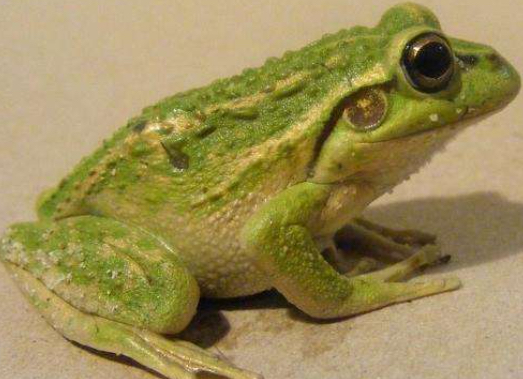

In [45]:
test_img = Image.open('../images/test_img/1.jpg')
test_img

In [46]:
test_img = transform(test_img)
# 添加一个维度使之满足Pytorch Tensor的通道排序  
# torch.unsqueeze():对数据维度进行扩充
test_img = torch.unsqueeze(test_img, dim=0) # [N, C, H, W]

In [47]:
with torch.no_grad():
    outputs = model(test_img)
    predict_softmax = torch.softmax(outputs, dim=1)
    predict_label = torch.max(outputs, dim=1)[1].data.numpy()

In [48]:
print(predict_softmax[0][0])

tensor(0.0003)


In [49]:
print(classes[int(predict_label)])

frog


## AlexNet

### 原理

`AlexNet`是第一个现代深度卷积网络模型，赢得了 2012 年 `ImageNet` 图像分类竞赛的冠军.其首次使用了很多现代深度卷积网络的技术方法.
- 使用 `GPU` 进行并行训练
- 采用 `ReLU` 作为非线性激活函数
- 使用两种正则化技术
    - `Dropout` 防止过拟合.(F9层和F10层,`Dropout`=50％)
    - 使用`数据增强`(随机变换训练图像的各种偏置量,水平翻转以及更改亮度条件)人为地增加训练集的大小,减少过拟合,来提高模型准确率等.<img src="../images/other/14-12.png" width="400">


<img src="../images/other/14-10.png" >

| 层 | 类型 | 特征图 | 大小 | Kernel size | Stride |Padding| 激活函数 |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| Out | Fully connected | - | 1,000 | - | - | - | Softmax |
| F10 | Fully connected | - | 4,096 | - | - | - | ReLU |
| F9 | Fully connected | - | 4,096 | - | - | - | ReLU |
| S8 | Max pooling | 256 | 6x6 | 3x3 | 2 | valid | - |
| C7 | Convolution | 256 | 13x13 | 3x3 | 1 | same | ReLU |
| C6 | Convolution | 384 | 13x13 | 3x3 | 1 | same | ReLU |
| C5 | Convolution | 384 | 13x13 | 3x3 | 1 | same | ReLU |
| S4 | Max pooling | 256 | 13x13 | 3x3 | 2 | valid | - |
| C3 | Convolution | 256 | 27x27 | 5x5 | 1 | same | ReLU |
| S2 | Max pooling | 96 | 27x27 | 3x3 | 2 | valid | - |
| C1 | Convolution | 96 | 55x55 | 11x11 | 4 | valid | ReLU |
| In | Input | 3 (RGB) | 227 x227 | - | - | - | - |

<img src="../images/other/14-11.png">

- `局部响应归一化LRN`

`AlexNet`在C1层和C3层的`ReLU`之后立即使用归一化步骤,成为`局部响应归一化LRN`:最强激活的神经元会抑制位于相邻特征图中相同位置的其他神经元.鼓励不同的特征图专业化,将它们分开,并迫使他们探索更广泛的特征,从而最终改善其泛化能力.

`局部响应归一化`和`层归一化`都是对同层的神经元进行归一化.不同的是,`局部响应归一化`应用在激活函数之后,只是对邻近的神经元进行局部归一化,并且不减去均值.

>假设一个卷积层的输出特征映射 $\boldsymbol{Y} \in \mathbb{R}^{M^{\prime} \times N^{\prime} \times P}$ 为三维张量, 其中每个切片 矩阵 $\boldsymbol{Y}^{\  \ p} \in \mathbb{R}^{M^{\prime} \times N^{\prime}}$ 为一个输出特征映射, $1 \leq p \leq P$.
局部响应归一化是对邻近的特征映射进行局部归一化.
$$
\begin{aligned}
\hat{{Y}}^{p} &=\frac{\boldsymbol{Y}^{\ \ p} }{\left(k+\alpha \sum_{j=\max \left(1, p-\frac{n}{2}\right)}^{\min \left(P, \frac{n}{2}\right)}\left(\boldsymbol{Y}^{\ \ j}\right)^{2}\right)^{\beta}} \\
& \triangleq \operatorname{LRN}_{n, k, \alpha, \beta}\left(\boldsymbol{Y}^{\ \ p}\right),
\end{aligned}
$$

其中除和幕运算都是按元素运算, $n, k, \alpha, \beta$ 为超参, $n$ 为局部归一化的特征窗口 大小. 在 `AlexNet` 中, 这些超参的取值为 $n=5, k=2, \alpha=10 \mathrm{e}^{-4}, \beta=0.75$.


`AlexNet`的变体`ZF Net`实质上是`AlexNet`带有一些结果调整的超参数.

`AlexNet`中每个池化层之后都有`LRN`。归一化层的目的是避免随着层级的加深而导致的信息出现逐层递减的趋势，起到加快神经网络收敛速度的作用。但是，近些年来的研究表明，`LRN`对神经网络的训练过程起到的帮助很小，所以就渐渐不再被使用了。

## GoogLeNet

### Inception 模块

#### 原理

在 `Inception`网络中,一个卷积层包含多个不同大小的卷积操作,称为 `Inception`模块. `Inception`网络是由有多个 `Inception`模块和少量的汇聚层堆叠而成.
<img src="../images/other/14-41.png">
`Inception`模块同时使用1×1、3×3、5×5等不同大小的卷积核,并将得到的特征映射在深度上拼接(堆叠)起来作为输出特征映射.
<img src="../images/other/14-15.png" width="400">

上图给出了v1版本(`GoogLeNet`)的 `Inception`模块结构

<img src="../images/other/14-14.png" width="400">
上图给出了具有降维功能的`Inception`模块

`3×3+1(s)`表示使用3×3的内核,步幅为1且填充为`SAME`.由于所有的单层都使用步幅为1且填充为`SAME`.因此它的们的输出都具有与输入相同的高度和宽度,这使得在`Depth concat`层中沿着深度维度合并所有的输出.

为了提高计算效率,减少参数数量, `Inception模块`中进行1×1的卷积来减少特征映射的深度.如果输入特征映射之间存在冗余信息,1×1的卷积相当于先进行一次特征抽取.

> **1. 可以看到有多个1x1卷积模块，这样的卷积有什么用处呢？**

- 作用1：在相同尺寸的感受野中叠加更多的卷积，能**提取到更丰富的特征**。这个观点来自于`Network in Network(NIN)`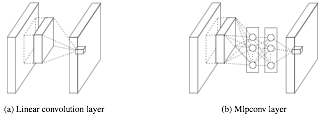
上图左侧是是传统的卷积层结构（线性卷积），在一个尺度上只有一次卷积；右图是`NIN结构`，先进行一次普通的卷积（比如3x3），紧跟再进行一次1x1的卷积，**对于某个像素点来说1x1卷积等效于该像素点在所有特征上进行一次全连接的计算**，所以右侧图的1x1卷积画成了全连接层的形式，需要注意的是NIN结构中无论是第一个3x3卷积还是新增的1x1卷积，后面都紧跟着激活函数（比如`relu`）。

   将两个卷积串联，就**能组合出更多的非线性特征**。举个例子，假设第1个3x3卷积＋激活函数近似于$f_1(x)=ax^2+bx+c$，第二个1x1卷积＋激活函数近似于$f_2(x)=mx^2+nx+q$.
   
   那$f_1(x)$和$f_2(f_1(x))$比哪个非线性更强，更能模拟非线性的特征？答案是显而易见的。`NIN`的结构和传统的神经网络中多层的结构有些类似，后者的多层是跨越了不同尺寸的感受野（通过层与层中间加`pool层`），从而在更高尺度上提取出特征；**`NIN结构`是在同一个尺度上的多层（中间没有pool层），从而在相同的感受野范围能提取更强的非线性。**
   
   
- 作用2：使用1x1卷积进行降维，**降低了计算复杂度**。3x3卷积和5x5卷积前的1x1卷积都起到了这个作用。当某个卷积层输入的特征数较多，对这个输入进行卷积运算将产生巨大的计算量；如果对输入先进行降维，减少特征数后再做卷积计算量就会显著减少。下图是优化前后两种方案的乘法次数比较<img src="../images/other/14-16.png">
同样是输入一组有192个特征、32x32大小，输出256组特征的数据，第一张图直接用3x3卷积实现，需要192x256x(3x3)x(32x32)=452 984 832；第二张图先用1x1的卷积降到96个特征，再用3x3卷积恢复出256组特征，需要192x96x(1x1)x(32x32)+96x256x(3x3)x(32x32)=245 366 784次乘法，使用1x1卷积降维的方法节省了一半的计算量。有人会问，用1x1卷积降到96个特征后特征数不就减少了么，会影响最后训练的效果么？答案是否定的，**只要最后输出的特征数不变（256组），中间的降维类似于压缩的效果，并不影响最终训练的结果**。

> **2. 对输入做了4个分支，分别用不同尺寸的`filter`进行卷积或池化，最后再在特征维度上拼接到一起。这种全新的结构有什么好处呢？**

- 解释1：在直观感觉上在多个尺度上同时进行卷积，能提取到不同尺度的特征。**特征更为丰富也意味着最后分类判断时更加准确.**


- 解释2：利用稀疏矩阵分解成密集矩阵计算的原理来加快收敛速度。举个例子下图左侧是个稀疏矩阵（很多元素都为0，不均匀分布在矩阵中），和一个2x2的矩阵进行卷积，需要对稀疏矩阵中的每一个元素进行计算；如果像右图那样把稀疏矩阵分解成2个子密集矩阵，再和2x2矩阵进行卷积，稀疏矩阵中0较多的区域就可以不用计算，计算量就大大降低。**这个原理应用到inception上就是要在特征维度上进行分解！**<img src="../images/other/14-17.jpg" width="400">
传统的卷积层的输入数据只和一种尺度（比如3x3）的卷积核进行卷积，输出固定维度（比如256个特征）的数据，所有256个输出特征基本上是均匀分布在3x3尺度范围上，这可以理解成输出了一个稀疏分布的特征集；而inception模块在多个尺度上提取特征（比如1x1，3x3，5x5），输出的256个特征就不再是均匀分布，而是相关性强的特征聚集在一起（比如1x1的的96个特征聚集在一起，3x3的96个特征聚集在一起，5x5的64个特征聚集在一起），这可以理解成多个密集分布的子特征集。这样的特征集中因为相关性较强的特征聚集在了一起，不相关的非关键特征就被弱化，同样是输出256个特征，**Inception方法输出的特征“冗余”的信息较少。用这样的“纯”的特征集层层传递最后作为反向计算的输入，自然收敛的速度更快。**


- 解释3：`Hebbin赫布原理`。Hebbin原理是神经科学上的一个理论，解释了在学习的过程中脑中的神经元所发生的变化，用一句话概括就是*fire togethter, wire together*。赫布认为“两个神经元或者神经元系统，如果总是同时兴奋，就会形成一种‘组合’，其中一个神经元的兴奋会促进另一个的兴奋”。比如狗看到肉会流口水，反复刺激后，脑中识别肉的神经元会和掌管唾液分泌的神经元会相互促进，“缠绕”在一起，以后再看到肉就会更快流出口水。用在Inception结构中就是要把相关性强的特征汇聚到一起。这有点类似上面的解释2，把1x1，3x3，5x5的特征分开。因为训练收敛的最终目的就是要提取出独立的特征，所以预先把相关性强的特征汇聚，就能起到加速收敛的作用。

Inception Module-深度解析:https://zhuanlan.zhihu.com/p/32702031

#### 使用Keras实现Inception模块

以`CIFAR-10`数据集为例,该数据集有10种不同类型的32×32像素的图片组成.

In [50]:
initialization()

In [51]:
# 加载数据集
cifar_10 = keras.datasets.cifar10.load_data()
(X_train, y_train), (X_test, y_test) = cifar_10

# 特征缩放
X_train = X_train / 255.0
X_test = X_test / 255.0

# 将标签转换为独热编码
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

<img src="../images/other/14-14.png" width="300">

In [52]:
# 使用函数式API创建模型
input_img = keras.layers.Input(shape = (32, 32, 3))
tower_1 = keras.layers.Conv2D(64, (1,1), padding='same', activation='relu')(input_img)

tower_2 = keras.layers.Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
tower_2 = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(tower_2)
 
tower_3 = keras.layers.Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
tower_3 = keras.layers.Conv2D(64, (5,5), padding='same', activation='relu')(tower_3)
 
tower_4 = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
tower_4 = keras.layers.Conv2D(64, (1,1), padding='same', activation='relu')(tower_4)
 
depth_concat = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4], 
                           axis=3) # 该轴是深度


output = keras.layers.Flatten()(depth_concat)
out = keras.layers.Dense(10, activation=keras.activations.softmax)(output)

In [53]:
from keras.models import Model

model = keras.models.Model(inputs=input_img, outputs=out)

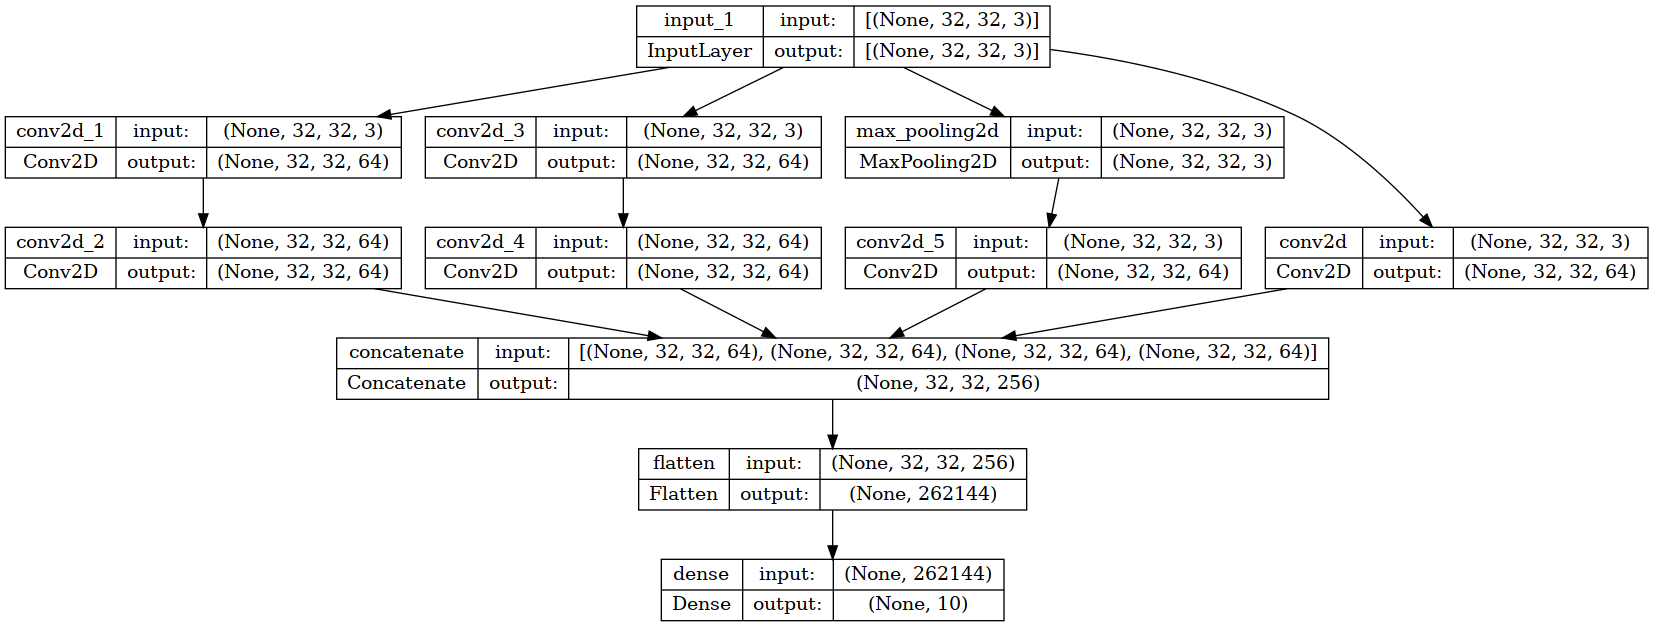

In [54]:
keras.utils.plot_model(model,
                       "../models/plot_model/Inception_Module.png",
                       show_shapes=True)

In [55]:
# 编译模型
epochs = 25
model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adam(learning_rate=5e-4), 
              metrics=["accuracy"])

# 训练模型
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=1)

1563/1563 [==============================] - 44s 28ms/step - loss: 1.4975 - accuracy: 0.4810 - val_loss: 1.2639 - val_accuracy: 0.5509


In [56]:
# 评估模型
score = model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 1.2639 - accuracy: 0.5509


In [57]:
model.save('../models/Inception_model.h5')

### GoogLeNet 架构

#### 原理

`GoogLeNet` CNN的架构如下图所示.
<img src="../images/other/14-18.png" width="400">
每个卷积层和每个池化层输出的特征图的数量在内核大小之前显示。`GoogLeNet`实际上是一个高堆叠,包括9个 `Inception`模块,其中的6个数字表示模块中每个卷积层输出的特征图的数量。请注意,所有卷积层都使用`ReLU`激活函数。 

<img src="../images/other/14-19.png" >
上表中的“#3x3 reduce”，“#5x5 reduce”表示在3x3，5x5卷积操作之前使用了1x1卷积的数量。

- 示例:`Inception (3a)`层
    
    分为四个分支，采用不同尺度的卷积核来进行处理
    1. 64个1x1的卷积核，然后`RuLU`，输出28x28x64
    2. 96个1x1的卷积核，作为3x3卷积核之前的降维，变成28x28x96，然后进行`ReLU`计算，再进行128个3x3的卷积（padding为1），输出28x28x128
    3. 16个1x1的卷积核，作为5x5卷积核之前的降维，变成28x28x16，进行`ReLU`计算后，再进行32个5x5的卷积（padding为2），输出28x28x32
    4. pool层，使用3x3的核（padding为1），输出28x28x192，然后进行32个1x1的卷积，输出28x28x32
    
  将四个结果进行连接，对这四部分输出结果的第三维并联，即64+128+32+32=256，最终输出28x28x256
  <img src="../images/other/14-20.png" width="500">

- 该图略有简化:原始的 `Googlenet`架构还包括两个`辅助分类器`,它们插入在第3和第6 个 `Inception`模块的顶部。它们都由一个平均池化层、一个卷积层、两个全连接层和一个 `softmax`激活层组成。在训练期间,它们的损失(减少了70%)被添加到总损失中,目的是解决梯度消失的问题并正则化,但后来证明其作用相对较小.
<img src="../images/other/14-21.png" width="400">

GoogLeNet网络结构明细表:https://blog.csdn.net/weixin_42764391/article/details/89713947

#### 完整架构图

<img src="../images/other/14-22.jpg">

#### 演示

1. 搭建模型

In [58]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten
from keras.models import Model
from keras.regularizers import l2
from keras.layers import concatenate

<img src="../images/other/14-20.png" width="500">

In [59]:
from functools import partial

default_Conv2D = partial(keras.layers.Conv2D,
                         activation=keras.activations.relu,
                         padding='SAME',
                         kernel_regularizer=l2(0.01))

default_MaxPool = partial(keras.layers.MaxPool2D,
                          pool_size=3,
                          strides=2,
                          padding='SAME')

In [60]:
# 定义Inception块
def inception_model(input, filters_1x1, filters_3x3_reduce, filters_3x3,
                    filters_5x5_reduce, filters_5x5, filters_pool_proj):
    conv_1x1 = default_Conv2D(filters=filters_1x1, kernel_size=1)(input)

    conv_3x3_reduce = default_Conv2D(filters=filters_3x3_reduce, kernel_size=1)(input)
    conv_3x3 = default_Conv2D(filters=filters_3x3, kernel_size=3)(conv_3x3_reduce)

    conv_5x5_reduce = default_Conv2D(filters=filters_5x5_reduce, kernel_size=1)(input)
    conv_5x5 = default_Conv2D(filters=filters_5x5, kernel_size=5)(conv_5x5_reduce)

    maxpool = MaxPooling2D(pool_size=3, strides=1, padding='same')(input)
    maxpool_proj = default_Conv2D(filters=filters_pool_proj,
                                  kernel_size=1,
                                  strides=1)(maxpool)

    inception_output = concatenate(
        [conv_1x1, conv_3x3, conv_5x5, maxpool_proj],
        axis=3)  # use tf as backend

    return inception_output

In [61]:
input = Input(shape=(224, 224, 3))

conv1_7x7_s2 = default_Conv2D(filters=64, kernel_size=7, strides=2)(input)
maxpool1_3x3_s2 = default_MaxPool()(conv1_7x7_s2)
conv2_3x3_reduce = default_Conv2D(filters=64, kernel_size=1)(maxpool1_3x3_s2)
conv2_3x3 = default_Conv2D(filters=192, kernel_size=3)(conv2_3x3_reduce)
maxpool2_3x3_s2 = default_MaxPool()(conv2_3x3)

inception_3a = inception_model(input=maxpool2_3x3_s2, 
                               filters_1x1=64, 
                               filters_3x3_reduce=96, 
                               filters_3x3=128, 
                               filters_5x5_reduce=16, 
                               filters_5x5=32, 
                               filters_pool_proj=32)

inception_3b = inception_model(input=inception_3a, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64)

maxpool3_3x3_s2 = default_MaxPool()(inception_3b)

inception_4a = inception_model(input=maxpool3_3x3_s2, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool_proj=64)

inception_4b = inception_model(input=inception_4a, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64)

inception_4c = inception_model(input=inception_4b, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64)

inception_4d = inception_model(input=inception_4c, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool_proj=64)

inception_4e = inception_model(input=inception_4d, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128)

maxpool4_3x3_s2 = default_MaxPool()(inception_4e)

inception_5a = inception_model(input=maxpool4_3x3_s2, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128)

inception_5b = inception_model(input=inception_5a, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool_proj=128)

averagepool1_7x7_s1 = AveragePooling2D(pool_size=7, strides=7, padding='same')(inception_5b)

drop1 = Dropout(rate=0.4)(averagepool1_7x7_s1)
linear = Flatten()(drop1)
output = Dense(units=10, activation="softmax", kernel_regularizer=l2(0.01))(linear)

model = Model(inputs=input, outputs=output)

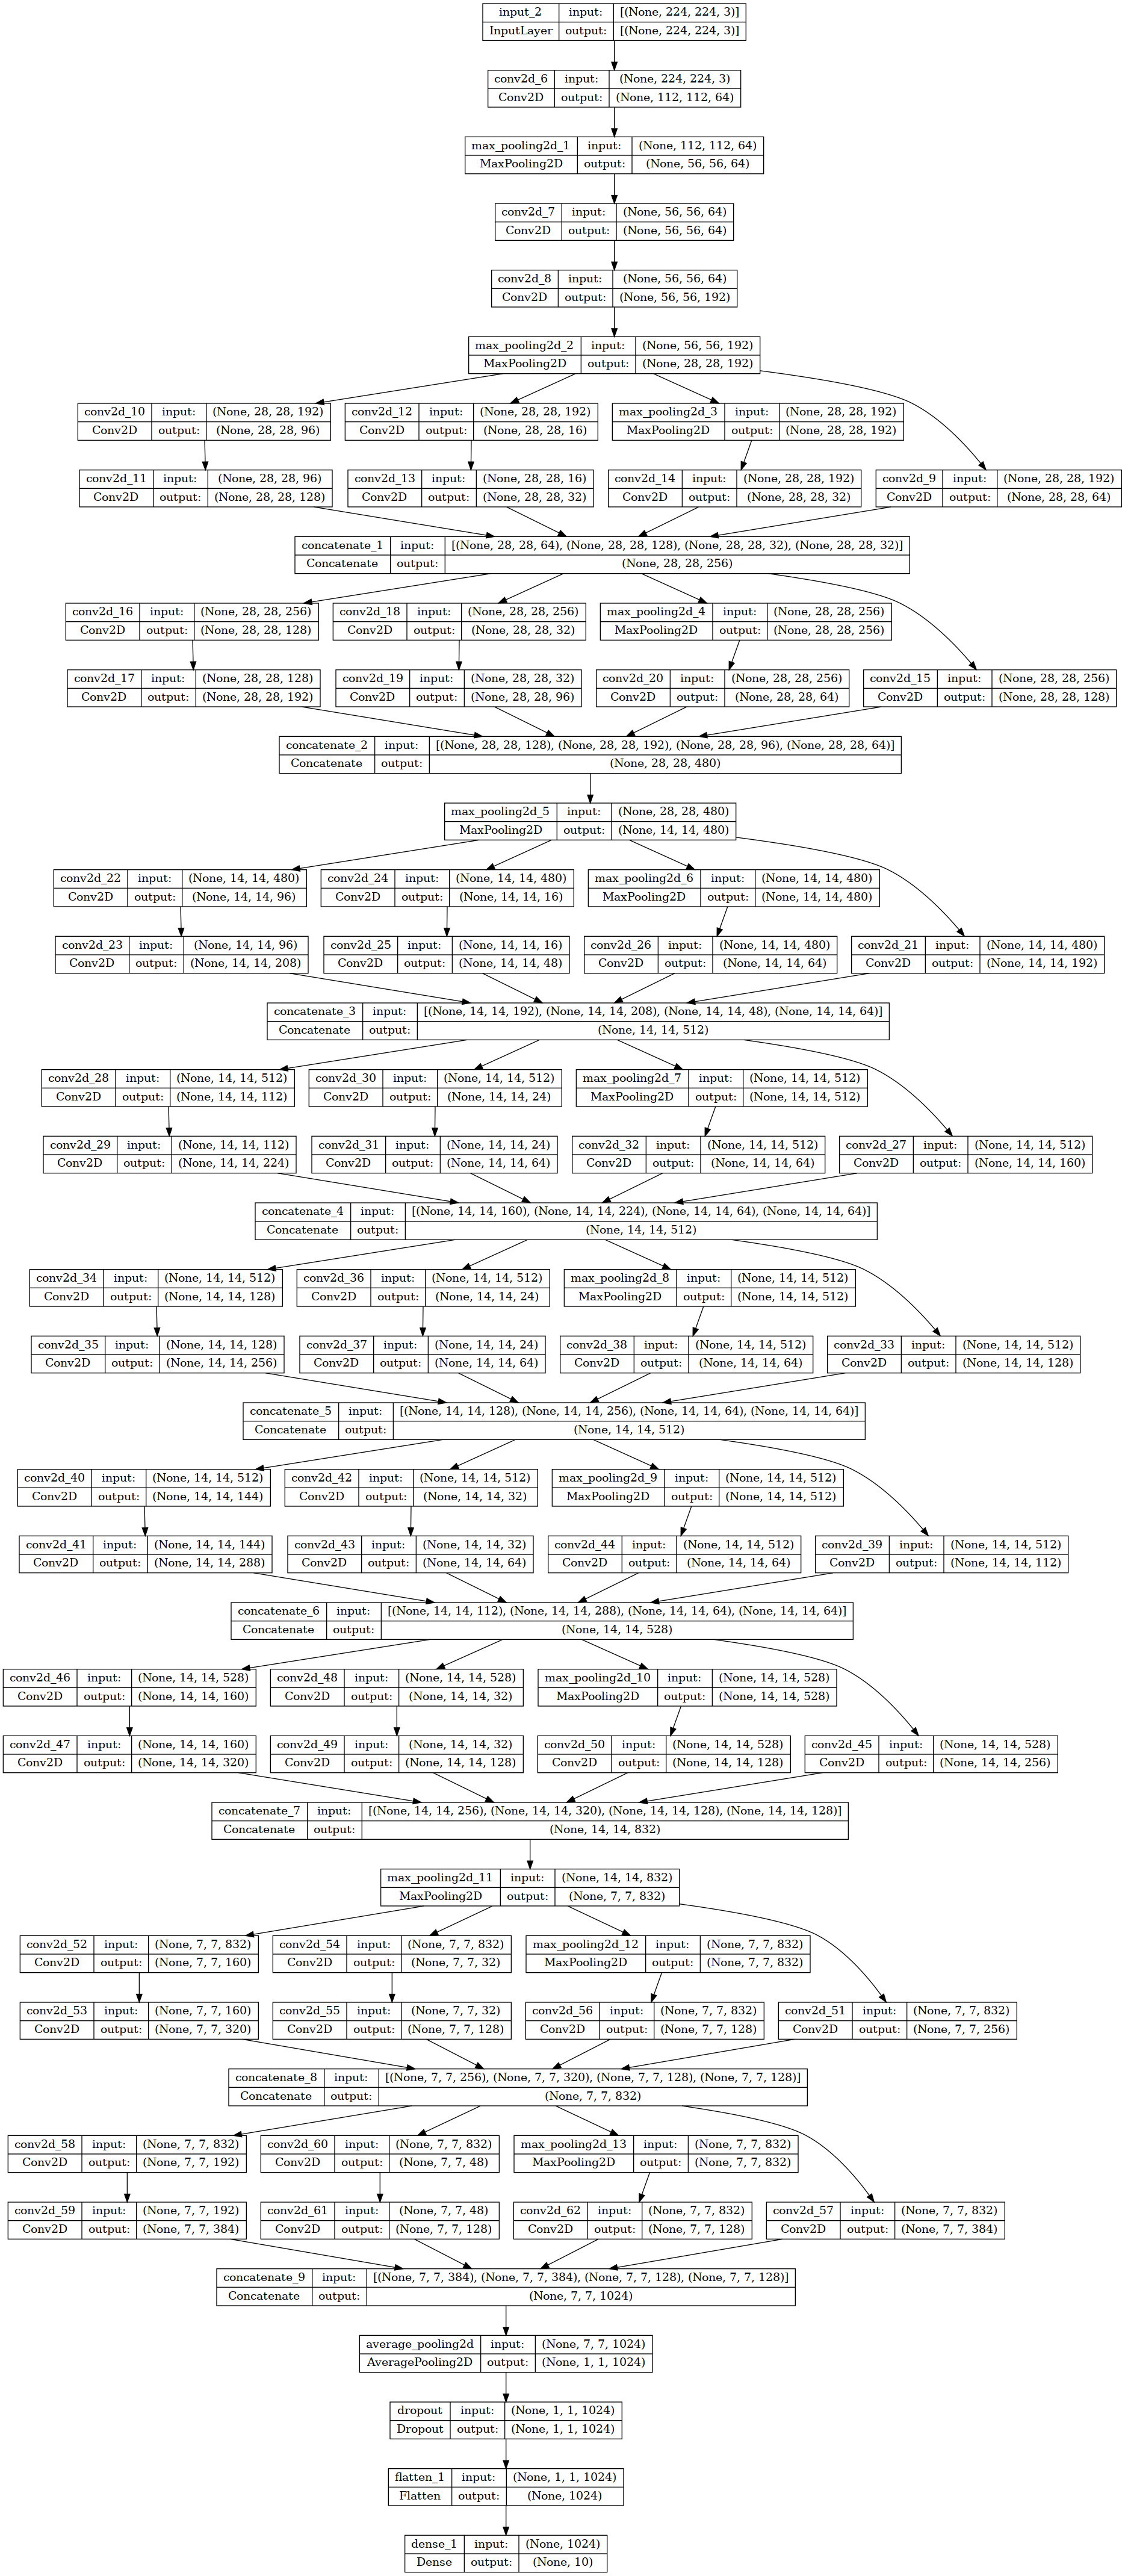

In [62]:
keras.utils.plot_model(model, "../models/plot_model/GoogLeNet_model.png", show_shapes=True)

2.加载,预处理数据集

- 加载TensorFlow 数据集项目,使用方法详见`第13章`

In [63]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("Cifar10", as_supervised=True, with_info=True)
# with_info:获取有关数据集的信息

In [64]:
class_names = info.features["label"].names
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

`Cifar10`数据集详细信息:https://tensorflow.google.cn/datasets/catalog/cifar10

In [65]:
train_set_raw = tfds.load("Cifar10", as_supervised=True)['train']

In [66]:
test_set_raw, valid_set_raw = tfds.load("Cifar10",
                                        split=["test[:60%]", "test[60%:]"],
                                        as_supervised=True)

2022-10-26 11:21:16.686851: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


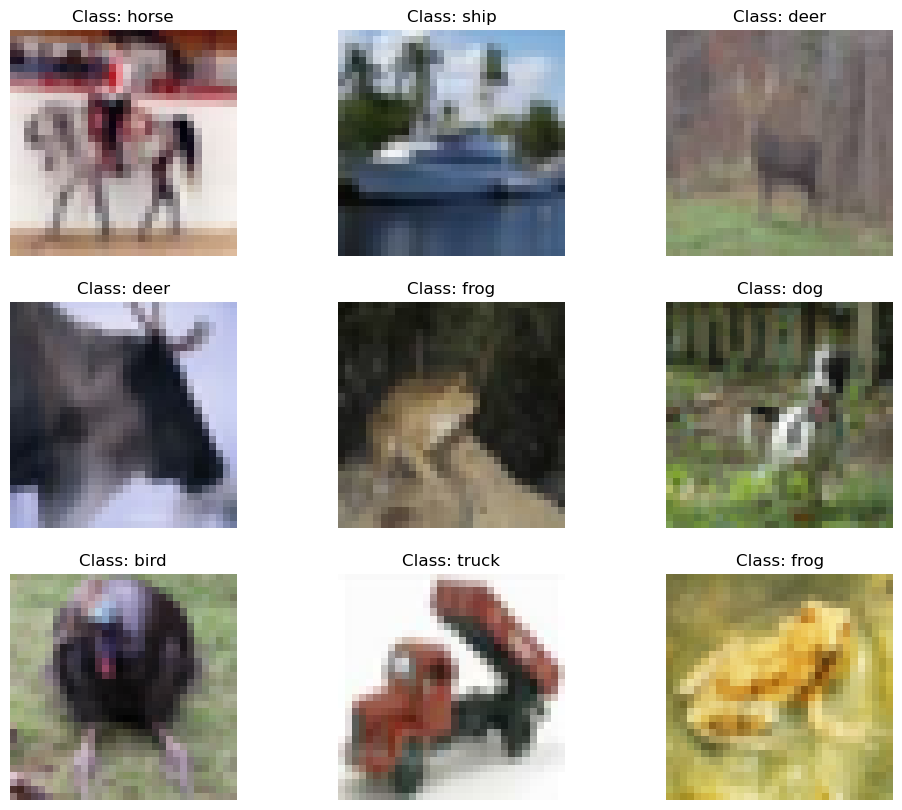

In [67]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
plt.show()

In [68]:
from keras.utils import np_utils


# 预处理
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    label = tf.cast(label, dtype=tf.int32)  # 数据类型转换
    label = tf.squeeze(label)  # tf.squeeze():用于从张量形状中移除大小为1的维度
    label = tf.one_hot(label, depth=10)
    return resized_image, label


batch_size = 64
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [69]:
import os
import time

In [70]:
root_logdir = os.path.join(os.curdir, "../Logs/my_GoogLeNet_logs")
root_logdir

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_dir = get_run_logdir()
run_dir

tensorboard_cb = keras.callbacks.TensorBoard(run_dir)

3. 训练评估模型

In [14]:
# 编译模型
optimizer = keras.optimizers.SGD(learning_rate=1e-3,
                                 momentum=0.9,
                                 nesterov=True,
                                 decay=0.001)
# 训练模型
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.4 * test_size / batch_size),
                    epochs=70,
                    callbacks=[tensorboard_cb])

Epoch 1/70


2022-03-11 12:57:38.122428: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/390 [..............................] - ETA: 1:25:24 - loss: 85.1026 - accuracy: 0.0469

2022-03-11 12:57:46.447804: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-11 12:57:46.447853: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/390 [..............................] - ETA: 3:56 - loss: 84.8974 - accuracy: 0.1016   

2022-03-11 12:57:46.961509: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-11 12:57:46.963592: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-03-11 12:57:47.122411: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1914 callback api events and 1911 activity events. 
2022-03-11 12:57:47.183708: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-11 12:57:47.269097: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ././Logs/my_GoogLeNet_logs/run_2022_03_11-12_57_32/train/plugins/profile/2022_03_11_12_57_47

2022-03-11 12:57:47.319661: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ././Logs/my_GoogLeNet_logs/run_2022_03_11-12_57_32/train/plugins/profile/2022_03_11_12_57_47/192896360c8f.trace.json.gz
2022-03-11 12:57:47.397418: 

390/390 [==============================] - 106s 237ms/step - loss: 79.0911 - accuracy: 0.2304 - val_loss: 74.0914 - val_accuracy: 0.3246
Epoch 2/70
390/390 [==============================] - 88s 227ms/step - loss: 70.4653 - accuracy: 0.3532 - val_loss: 67.1364 - val_accuracy: 0.4050
Epoch 3/70
390/390 [==============================] - 88s 226ms/step - loss: 64.4996 - accuracy: 0.4087 - val_loss: 62.0821 - val_accuracy: 0.4317
Epoch 4/70
390/390 [==============================] - 88s 227ms/step - loss: 60.0262 - accuracy: 0.4475 - val_loss: 58.1655 - val_accuracy: 0.4647
Epoch 5/70
390/390 [==============================] - 88s 227ms/step - loss: 56.5007 - accuracy: 0.4761 - val_loss: 54.9123 - val_accuracy: 0.5126
Epoch 6/70
390/390 [==============================] - 88s 227ms/step - loss: 53.6202 - accuracy: 0.4974 - val_loss: 52.3579 - val_accuracy: 0.5048
Epoch 7/70
390/390 [==============================] - 88s 227ms/step - loss: 51.1991 - accuracy: 0.5182 - val_loss: 50.0735 - va

In [15]:
model.save('../models/GoogLeNet_model.h5')

In [16]:
model = keras.models.load_model("../models/GoogLeNet_model.h5")
model.evaluate(test_set)

47/47 [==============================] - 7s 135ms/step - loss: 22.9746 - accuracy: 0.6985


[22.97458267211914, 0.6984999775886536]

In [72]:
%load_ext tensorboard
%tensorboard --logdir=../Logs/my_GoogLeNet_logs --port=6061

<img src="../images/other/14-56.png">

> create:Apotosome 01/24/22

> update:Apotosome 10/26/22